In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np

from models.MLP import MLP

In [12]:
hidden_dim = 48
layers = 2
output_dim = 1
learning_rate = 0.00005
num_epochs = 3000
epochs_step = 10
batch_size = 32
test_size=0.3
dropout_rate = 0.5
pos_weight_ratio = 1600
ds_name = '20220328-or-eng-full.csv'
train = True

In [13]:
data = pd.read_csv(ds_name)

# removed_cols = ['Postoperative Olanzapine', 'Postoperative Fluphenazine', 'Postoperative Flupentixol']
# data = data.drop(removed_cols, axis=1)

# 将特征和目标分开
features = data.drop('Label', axis=1).values
target = data['Label'].values

print(features.shape)
print(target.shape)

(1809, 101)
(1809,)


In [14]:
# 划分训练集和测试集
train_features, test_features, train_target, test_target = train_test_split(
    features, target, test_size=test_size, random_state=42)

In [15]:
# 将数据转换为PyTorch张量
train_features = torch.Tensor(train_features)
test_features = torch.Tensor(test_features)
train_target = torch.tensor(train_target, dtype=torch.float32).view(-1, 1)
test_target = torch.tensor(test_target, dtype=torch.float32).view(-1, 1)

train_dataset = TensorDataset(train_features, train_target)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

input_dim = train_features.shape[1]

In [16]:
# Random seed
torch.manual_seed(42)

model = MLP(input_dim, hidden_dim, output_dim,
            layers=layers, dropout_rate=dropout_rate)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

pos_weight = torch.tensor(
    len(train_target) / (2 * torch.sum(train_target)), dtype=torch.float32)
print(pos_weight)
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight*pos_weight_ratio)

# To device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = torch.device('cpu')
torch.set_float32_matmul_precision('high')

model = model.to(device)
criterion = criterion.to(device)

train_features = train_features.to(device)
test_features = test_features.to(device)
train_target = train_target.to(device)
test_target = test_target.to(device)

# Compile model
model = torch.compile(model)

/tmp/ipykernel_173982/3312115475.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pos_weight = torch.tensor(


tensor(12.6600)


In [17]:
def train_model(model, criterion, optimizer, num_epochs=100):
    train_losses = []
    test_accs = []
    sensitivities = []
    sppecificities = []
    for epoch in tqdm(range(num_epochs)):
        model.train()

        if epoch == num_epochs // 2:
            criterion = nn.BCEWithLogitsLoss(
                pos_weight=pos_weight*pos_weight_ratio)
            criterion = criterion.to(device)

        train_loss = 0.0
        for batch_idx, (data, target) in enumerate(train_loader):
            optimizer.zero_grad()
            # To device
            data = data.to(device)
            target = target.to(device)

            outputs = model(data)
            loss = criterion(outputs, target)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        # save model
        if (epoch + 1) % epochs_step == 0:
            # test
            train_loss /= len(train_loader)
            train_losses.append(train_loss)
            model.eval()
            outputs = model(test_features)
            outputs = outputs > 0.5
            acc = torch.sum(outputs == test_target).item() / len(test_target)
            test_accs.append(acc)

            sensitivity = torch.sum(outputs[test_target == 1] == 1).item(
            ) / torch.sum(test_target == 1).item()
            sensitivities.append(sensitivity)

            sppecificity = torch.sum(outputs[test_target == 0] == 0).item(
            ) / torch.sum(test_target == 0).item()
            sppecificities.append(sppecificity)

            # torch.save(model.state_dict(),
            #            'pths/MLP-epoch-{}-acc-{:.4f}-sens-{:.4f}.pth'.format(epoch+1, acc*100, sensitivity*100))
    
            if (epoch + 1) % (epochs_step*10)== 0:
                print('Epoch [{}/{}], Loss: {:.4f}, Acc: {:.4f}, Sens: {:.4f}, Spec: {:.4f}'
                      .format(epoch + 1, num_epochs, train_loss, acc, sensitivity, sppecificity))
    
    return train_losses, test_accs, sensitivities, sppecificities

Number of positive samples: 50
Number of negative samples: 1216


  3%|▎         | 101/3000 [00:08<04:59,  9.69it/s]

Epoch [100/3000], Loss: 12.4805, Acc: 0.0331, Sens: 1.0000, Spec: 0.0000


  7%|▋         | 201/3000 [00:16<04:08, 11.25it/s]

Epoch [200/3000], Loss: 7.5027, Acc: 0.0571, Sens: 1.0000, Spec: 0.0248


 10%|█         | 302/3000 [00:25<03:31, 12.74it/s]

Epoch [300/3000], Loss: 6.5130, Acc: 0.1123, Sens: 1.0000, Spec: 0.0819


 13%|█▎        | 402/3000 [00:33<03:25, 12.63it/s]

Epoch [400/3000], Loss: 6.0394, Acc: 0.1786, Sens: 1.0000, Spec: 0.1505


 17%|█▋        | 500/3000 [00:41<03:30, 11.85it/s]

Epoch [500/3000], Loss: 5.4031, Acc: 0.2413, Sens: 1.0000, Spec: 0.2152


 20%|██        | 600/3000 [00:50<03:47, 10.54it/s]

Epoch [600/3000], Loss: 4.9459, Acc: 0.2873, Sens: 1.0000, Spec: 0.2629


 23%|██▎       | 701/3000 [01:01<03:03, 12.56it/s]

Epoch [700/3000], Loss: 5.4082, Acc: 0.3499, Sens: 1.0000, Spec: 0.3276


 27%|██▋       | 801/3000 [01:09<03:27, 10.60it/s]

Epoch [800/3000], Loss: 5.0983, Acc: 0.4236, Sens: 0.9444, Spec: 0.4057


 30%|███       | 900/3000 [01:19<03:06, 11.29it/s]

Epoch [900/3000], Loss: 4.1510, Acc: 0.4715, Sens: 0.9444, Spec: 0.4552


 33%|███▎      | 1002/3000 [01:27<03:02, 10.95it/s]

Epoch [1000/3000], Loss: 5.4816, Acc: 0.5046, Sens: 0.9444, Spec: 0.4895


 37%|███▋      | 1102/3000 [01:36<02:45, 11.49it/s]

Epoch [1100/3000], Loss: 3.2871, Acc: 0.5543, Sens: 0.8889, Spec: 0.5429


 40%|████      | 1201/3000 [01:45<02:25, 12.35it/s]

Epoch [1200/3000], Loss: 3.6501, Acc: 0.5875, Sens: 0.8889, Spec: 0.5771


 43%|████▎     | 1301/3000 [01:54<02:19, 12.15it/s]

Epoch [1300/3000], Loss: 3.0067, Acc: 0.6262, Sens: 0.8889, Spec: 0.6171


 47%|████▋     | 1401/3000 [02:03<02:15, 11.82it/s]

Epoch [1400/3000], Loss: 2.5660, Acc: 0.6519, Sens: 0.8889, Spec: 0.6438


 50%|█████     | 1501/3000 [02:11<02:12, 11.33it/s]

Epoch [1500/3000], Loss: 2.6247, Acc: 0.6906, Sens: 0.8333, Spec: 0.6857


 53%|█████▎    | 1601/3000 [02:20<02:00, 11.63it/s]

Epoch [1600/3000], Loss: 2.1406, Acc: 0.7109, Sens: 0.8333, Spec: 0.7067


 57%|█████▋    | 1701/3000 [02:28<01:50, 11.71it/s]

Epoch [1700/3000], Loss: 2.1089, Acc: 0.7403, Sens: 0.8333, Spec: 0.7371


 60%|██████    | 1801/3000 [02:37<01:43, 11.61it/s]

Epoch [1800/3000], Loss: 2.2473, Acc: 0.7643, Sens: 0.7778, Spec: 0.7638


 63%|██████▎   | 1901/3000 [02:45<01:34, 11.58it/s]

Epoch [1900/3000], Loss: 1.9709, Acc: 0.7716, Sens: 0.7222, Spec: 0.7733


 67%|██████▋   | 2001/3000 [02:54<01:35, 10.45it/s]

Epoch [2000/3000], Loss: 1.8073, Acc: 0.8048, Sens: 0.6667, Spec: 0.8095


 70%|███████   | 2101/3000 [03:03<01:17, 11.54it/s]

Epoch [2100/3000], Loss: 1.7522, Acc: 0.8140, Sens: 0.6667, Spec: 0.8190


 73%|███████▎  | 2201/3000 [03:12<01:05, 12.11it/s]

Epoch [2200/3000], Loss: 1.6201, Acc: 0.8287, Sens: 0.6111, Spec: 0.8362


 77%|███████▋  | 2301/3000 [03:20<01:00, 11.56it/s]

Epoch [2300/3000], Loss: 1.9219, Acc: 0.8361, Sens: 0.6111, Spec: 0.8438


 80%|████████  | 2402/3000 [03:29<00:50, 11.96it/s]

Epoch [2400/3000], Loss: 1.2789, Acc: 0.8453, Sens: 0.6111, Spec: 0.8533


 83%|████████▎ | 2502/3000 [03:38<00:41, 11.88it/s]

Epoch [2500/3000], Loss: 1.7963, Acc: 0.8471, Sens: 0.5556, Spec: 0.8571


 87%|████████▋ | 2602/3000 [03:47<00:38, 10.32it/s]

Epoch [2600/3000], Loss: 1.1595, Acc: 0.8674, Sens: 0.5000, Spec: 0.8800


 90%|█████████ | 2702/3000 [03:56<00:27, 10.71it/s]

Epoch [2700/3000], Loss: 1.1606, Acc: 0.8692, Sens: 0.5000, Spec: 0.8819


 93%|█████████▎| 2802/3000 [04:05<00:18, 10.89it/s]

Epoch [2800/3000], Loss: 1.0222, Acc: 0.8766, Sens: 0.5000, Spec: 0.8895


 97%|█████████▋| 2902/3000 [04:14<00:08, 10.94it/s]

Epoch [2900/3000], Loss: 0.8417, Acc: 0.8840, Sens: 0.5000, Spec: 0.8971


100%|██████████| 3000/3000 [04:24<00:00, 11.35it/s]


Epoch [3000/3000], Loss: 0.9589, Acc: 0.8877, Sens: 0.5000, Spec: 0.9010


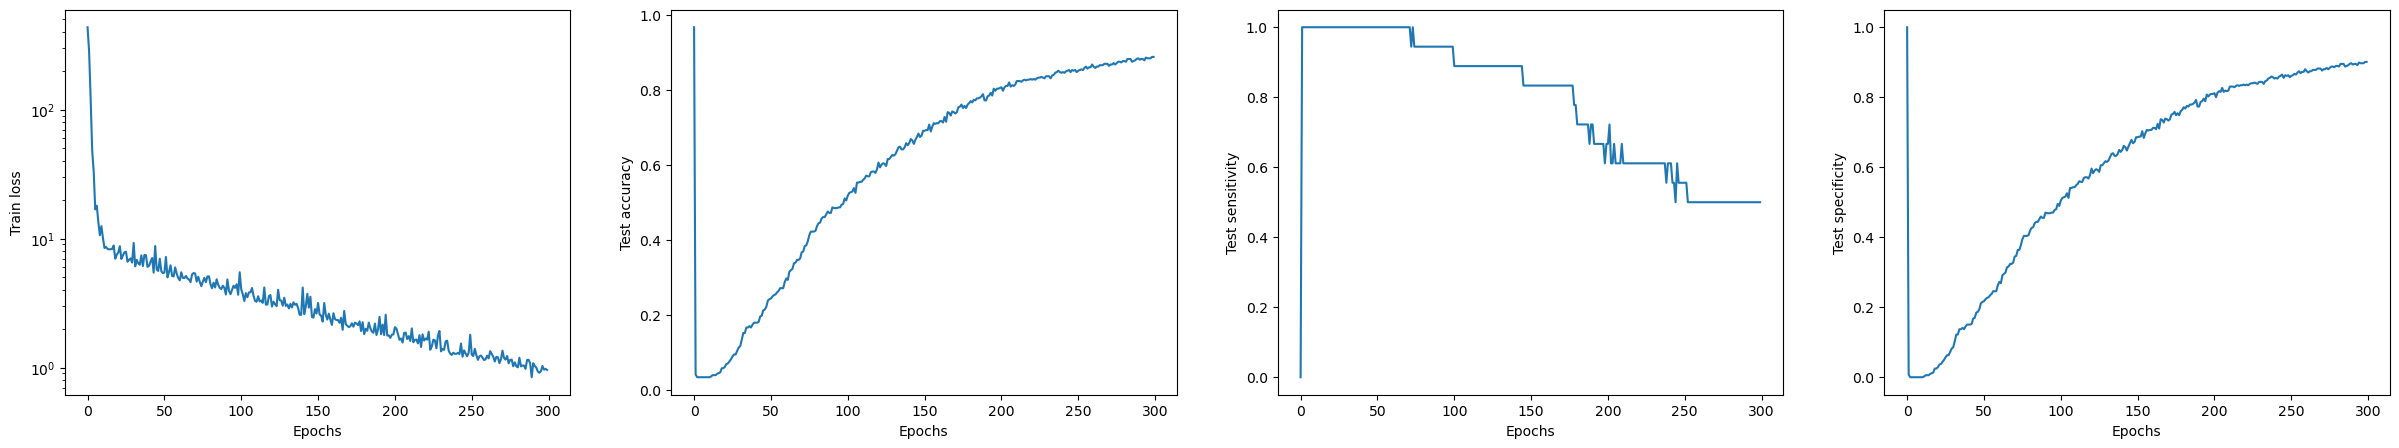

In [18]:
if train == True:
    # torch._dynamo.config.suppress_errors = True

    # Count number of positive and negative samples
    print('Number of positive samples: {}'.format((train_target == 1).sum()))
    print('Number of negative samples: {}'.format((train_target == 0).sum()))

    train_losses, test_accs, sensitivities, sppecificities = train_model(
        model, criterion, optimizer, num_epochs=num_epochs)

    # Plot losses and accuracies separately
    fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(30, 5))
    ax[0].plot(train_losses)
    ax[0].set_xlabel('Epochs')
    ax[0].set_ylabel('Train loss')
    ax[0].set_yscale('log')
    ax[1].plot(test_accs)
    ax[1].set_xlabel('Epochs')
    ax[1].set_ylabel('Test accuracy')
    ax[2].plot(sensitivities)
    ax[2].set_xlabel('Epochs')
    ax[2].set_ylabel('Test sensitivity')
    ax[3].plot(sppecificities)
    ax[3].set_xlabel('Epochs')
    ax[3].set_ylabel('Test specificity')
    
    plt.savefig('MLP-{:04}-{:02.4f}.png'.format(num_epochs, test_accs[-1]*100))
    plt.show()

    torch.save(model.state_dict(), 'pths/MLP-epoch-{}-acc-{:.4f}-sens-{:.4f}.pth'.format(num_epochs, test_accs[-1]*100, sensitivities[-1]*100))

In [19]:
def test_model(model, features, target):
    # Test in all data
    model.eval()
    outputs = model(features)
    outputs = outputs > 0.5

    # Reshape
    outputs = outputs.view(-1)
    target = target.view(-1)
    success = torch.sum(outputs == target).item()
    print('Success: {}/{}'.format(success, len(target)))

    acc = success / len(target)
    print('Accuracy: {:.2f}'.format(acc))

    # Confusion matrix
    TP = torch.sum((outputs == 1) & (target == 1)).item()
    TN = torch.sum((outputs == 0) & (target == 0)).item()
    FP = torch.sum((outputs == 1) & (target == 0)).item()
    FN = torch.sum((outputs == 0) & (target == 1)).item()

    print('TP: {}, TN: {}, FP: {}, FN: {}'.format(TP, TN, FP, FN))

    sensitivity = TP / (TP + FN)
    specificity = TN / (TN + FP)
    print('Sensitivity: {:.2f}, Specificity: {:.2f}'.format(sensitivity, specificity))

In [20]:
# Load model
# model.load_state_dict(torch.load('pths/MLP-500-9.5580e-01.pth'))

print('In test set:')
test_model(model, test_features, test_target)

print('\nIn all data:')
test_model(model, torch.Tensor(features).to(device), torch.Tensor(target).to(device))

In test set:
Success: 482/543
Accuracy: 0.89
TP: 9, TN: 473, FP: 52, FN: 9
Sensitivity: 0.50, Specificity: 0.90

In all data:
Success: 1638/1809
Accuracy: 0.91
TP: 59, TN: 1579, FP: 162, FN: 9
Sensitivity: 0.87, Specificity: 0.91
